# Spatial predictors

In the focal site multi-scale study framework <cite data-cite="brennen2002focal"/>, a response variable (e.g., species abundance) is measured at multiple sites and the predictor variables are usually measures of landscape structure (e.g. habitat amount and configuration) computed at multiple spatial extents surrounding each focal site. The utility of such a framework transcends species-landscape relationships - in fact, land use regressions to predict air quality or temperature based on multi-scale spatial predictors fundamentally share the same setup <cite data-cite="hoek2008review" />.

A key aspect of focal site multi-scale studies is the selection of spatial predictors, which are ultimately used as explanatory variables to study the effect of spatial pattern on a response variable.

In [ ]:
import contextily as cx
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio as rio
import seaborn as sns

import focalpy

In [ ]:
stations_filepath = "data/stations.gpkg"

buildings_filepath = "data/buildings.gpkg"
tree_canopy_filepath = "data/tree-canopy.tif"
dem_filepath = "data/dem.tif"
lulc_filepath = "data/lulc.tif"

buffer_dists = [50, 100, 250, 500]

In [ ]:
stations_gdf = gpd.read_file(stations_filepath).set_index("station_id")

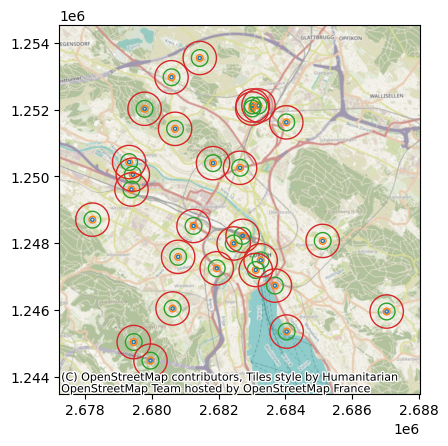

In [ ]:
fig, ax = plt.subplots()
for buffer_dist, color in zip(buffer_dists, sns.color_palette()):
    stations_gdf.buffer(buffer_dist).plot(
        facecolor=(0, 0, 0, 0), edgecolor=color, ax=ax
    )
cx.add_basemap(ax, crs=stations_gdf.crs)

In [ ]:
# buildings
buildings_gdf = gpd.read_file(buildings_filepath).set_index("id")
# add a "volume" column
buildings_gdf["volume"] = buildings_gdf["area"] * buildings_gdf["height"]
buildings_gdf.head()

,height,area,geometry,volume
id,,,,
4264,18.670619,10340.626863,"POLYGON ((2680693.885 1251498.715, 2680695.967...",193065.902368
4436,16.988255,5692.331205,"POLYGON ((2682125.575 1247611.584, 2682110.688...",96702.775194
4633,21.344529,3200.633956,"POLYGON ((2683816.74 1248231.125, 2683816.581 ...",68316.025064
7565,23.081217,3083.217221,"POLYGON ((2683434.771 1248110.727, 2683434.099...",71164.405863
57243,15.070181,1032.077993,"POLYGON ((2683508.7 1247190.211, 2683519.131 1...",15553.602132


In [ ]:
# dem
with rio.open(dem_filepath) as src:
    # read the one and only band
    dem_arr = src.read(1)
    dem_transform = src.transform
    dem_nodata = src.nodata

## Computing features

In [ ]:
fa = focalpy.FocalAnalysis(
    [buildings_gdf, tree_canopy_filepath, dem_filepath],
    stations_gdf,
    buffer_dists,
    [
        "compute_vector_features",
        "compute_raster_features",
        "compute_terrain_attributes",
    ],
    feature_col_prefixes=["building", "tree", ""],
    feature_methods_args={
        "compute_vector_features": [{"volume": "sum"}],
        "compute_terrain_attributes": [["slope", "topographic_position_index"]],
    },
    feature_methods_kwargs={
        "compute_raster_features": {"stats": "sum"},
        "compute_terrain_attributes": {"stats": "mean"},
    },
)
fa.features_df.head()

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

,building_volume_sum_50,building_volume_sum_100,building_volume_sum_250,building_volume_sum_500,tree_sum_50,tree_sum_100,tree_sum_250,tree_sum_500,slope_mean_50,slope_mean_100,slope_mean_250,slope_mean_500,topographic_position_index_mean_50,topographic_position_index_mean_100,topographic_position_index_mean_250,topographic_position_index_mean_500
station_id,,,,,,,,,,,,,,,,
2651,42799.252900,130087.412717,5.394371e+05,1.874661e+06,650.0,2281.0,12913.0,59364.0,6.258385,5.147757,3.865617,3.948312,0.002324,0.001576,0.000070,-0.000084
2652,28891.012664,100381.131949,6.930643e+05,2.925047e+06,134.0,1607.0,10679.0,38572.0,3.295830,3.792125,3.354241,3.435203,-0.000874,0.000531,-0.000046,-0.000022
2653,8218.052929,39102.191933,3.850106e+05,1.081819e+06,845.0,3211.0,18900.0,83168.0,6.053758,5.753644,6.210232,8.461916,0.000385,0.000706,0.000689,0.000174
2655,69366.625859,330706.307361,1.378667e+06,4.091401e+06,149.0,1005.0,9609.0,33100.0,1.742169,1.645347,2.092990,3.686358,-0.000051,-0.000204,-0.000106,-0.000154
2656,0.000000,360.659244,8.534503e+03,1.080769e+04,1950.0,7070.0,40955.0,172565.0,27.618801,29.190599,28.890853,29.256348,0.011389,0.003584,0.002101,0.000425


In [ ]:
# ### Vector data
# #### Basic geopandas operations

In [ ]:
focalpy.compute_vector_features(
    buildings_gdf, stations_gdf, buffer_dists, gb_reduce_method="size"
)

size
station_id buffer_dist       
2651       50             6.0
           100           19.0
           250          124.0
           500          552.0
2652       50             8.0
...                       ...
SMA        500          555.0
UEB        50             2.0
           100            2.0
           250           20.0
           500           32.0

[112 rows x 1 columns]

In [ ]:
focalpy.compute_vector_features(buildings_gdf, stations_gdf, buffer_dists, "mean")

height_mean   area_mean  volume_mean
station_id buffer_dist                                      
2651       50             16.863535  423.278173  7133.208817
           100            15.645063  427.571637  6846.705932
           250            10.056238  339.999499  4350.298985
           500             8.837930  278.871534  3396.125261
2652       50             18.997770  191.284786  3611.376583
...                             ...         ...          ...
SMA        500             8.645853  192.181419  1837.771486
UEB        50              2.683603  183.051163   973.190031
           100             2.683603  183.051163   973.190031
           250             9.355363  167.553049  1246.004972
           500             9.658524  132.610983   984.392390

[112 rows x 3 columns]

In [ ]:
focalpy.compute_vector_features(
    buildings_gdf, stations_gdf, buffer_dists, {"area": "sum", "height": "mean"}
)

area_sum  height_mean
station_id buffer_dist                            
2651       50             2539.669037    16.863535
           100            8123.861097    15.645063
           250           42159.937823    10.056238
           500          153937.086847     8.837930
2652       50             1530.278291    18.997770
...                               ...          ...
SMA        500          106660.687706     8.645853
UEB        50              366.102327     2.683603
           100             366.102327     2.683603
           250            3351.060986     9.355363
           500            4243.551471     9.658524

[112 rows x 2 columns]

In [ ]:
focalpy.compute_vector_features(
    buildings_gdf, stations_gdf, buffer_dists, ["sum", "mean"]
)

height_sum  height_mean       area_sum   area_mean  \
station_id buffer_dist                                                        
2651       50            101.181213    16.863535    2539.669037  423.278173   
           100           297.256202    15.645063    8123.861097  427.571637   
           250          1246.973527    10.056238   42159.937823  339.999499   
           500          4878.537480     8.837930  153937.086847  278.871534   
2652       50            151.982158    18.997770    1530.278291  191.284786   
...                             ...          ...            ...         ...   
SMA        500          4798.448197     8.645853  106660.687706  192.181419   
UEB        50              5.367206     2.683603     366.102327  183.051163   
           100             5.367206     2.683603     366.102327  183.051163   
           250           187.107254     9.355363    3351.060986  167.553049   
           500           309.072774     9.658524    4243.551471  132.610983   

                          volume_sum  volume_mean  
station_id buffer_dist                             
2651       50           4.279925e+04  7133.208817  
           100          1.300874e+05  6846.705932  
           250          5.394371e+05  4350.298985  
           500          1.874661e+06  3396.125261  
2652       50           2.889101e+04  3611.376583  
...                              ...          ...  
SMA        500          1.019963e+06  1837.771486  
UEB        50           1.946380e+03   973.190031  
           100          1.946380e+03   973.190031  
           250          2.492010e+04  1246.004972  
           500          3.150056e+04   984.392390  

[112 rows x 6 columns]

In [ ]:
focalpy.compute_vector_features(
    buildings_gdf.assign(**{"volume": buildings_gdf["area"] * buildings_gdf["height"]}),
    stations_gdf,
    buffer_dists,
    {"volume": "mean"},
)

volume_mean
station_id buffer_dist             
2651       50           7133.208817
           100          6846.705932
           250          4350.298985
           500          3396.125261
2652       50           3611.376583
...                             ...
SMA        500          1837.771486
UEB        50            973.190031
           100           973.190031
           250          1246.004972
           500           984.392390

[112 rows x 1 columns]

#### Urban morphometrics (momepy)

In [ ]:
focalpy.compute_urban_morphometrics(
    buildings_gdf,
    stations_gdf,
    buffer_dists,
    ["circular_compactness", "fractal_dimension"],
    "mean",
)

circular_compactness_mean  fractal_dimension_mean
station_id buffer_dist                                                   
2651       50                            0.553636                1.022197
           100                           0.550181                1.023150
           250                           0.538925                1.030278
           500                           0.519466                1.041202
2652       50                            0.538450                1.022200
...                                           ...                     ...
SMA        500                           0.550440                1.034010
UEB        50                            0.700509                0.916253
           100                           0.700509                0.916253
           250                           0.517528                1.049154
           500                           0.530266                1.046731

[112 rows x 2 columns]

In [ ]:
focalpy.compute_urban_morphometrics(
    buildings_gdf,
    stations_gdf,
    buffer_dists,
    ["circular_compactness", "form_factor"],
    "mean",
    momepy_metrics_kwargs_dict={"form_factor": {"height": buildings_gdf["height"]}},
)

circular_compactness_mean  form_factor_mean
station_id buffer_dist                                             
2651       50                            0.553636          5.146849
           100                           0.550181          5.183737
           250                           0.538925         36.460616
           500                           0.519466         15.382184
2652       50                            0.538450          5.587796
...                                           ...               ...
SMA        500                           0.550440          5.911815
UEB        50                            0.700509         19.259741
           100                           0.700509         19.259741
           250                           0.517528         24.733243
           500                           0.530266         17.679633

[112 rows x 2 columns]

### Raster data
#### Basic raster operations (zonal statistics with rasterstats)

In [ ]:
focalpy.compute_raster_features(
    dem_arr,
    stations_gdf,
    buffer_dists,
    affine=dem_transform,
    stats="mean",
    nodata=dem_nodata,
)

mean
station_id buffer_dist            
2651       50           455.053617
           100          454.768099
           250          453.078239
           500          453.072617
2652       50           406.412919
...                            ...
SMA        500          560.063654
UEB        50           853.093014
           100          844.082015
           250          803.673862
           500          748.301653

[112 rows x 1 columns]

In [ ]:
with rio.open(lulc_filepath) as src:
    # read the one and only band
    lulc_arr = src.read(1)
    lulc_transform = src.transform

target_class = 5  # urban green spaces
focalpy.compute_raster_features(
    lulc_arr == target_class,
    stations_gdf,
    buffer_dists,
    affine=lulc_transform,
    stats=["sum", "mean"],
)

/home/martibosch/libraries/focalpy/.pixi/envs/user-guide/lib/python3.13/site-packages/rasterstats/io.py:335: NodataWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn(


mean  sum
station_id buffer_dist               
2651       50           0.000000  0.0
           100          0.000000  0.0
           250          0.000000  0.0
           500          0.000801  1.0
2652       50           0.000000  0.0
...                          ...  ...
SMA        500          0.004785  6.0
UEB        50           0.000000  0.0
           100          0.000000  0.0
           250          0.000000  0.0
           500          0.000000  0.0

[112 rows x 2 columns]

### Landscape metrics (pylandstats)

In [ ]:
# green spaces (5), meadows/pastures (8) and forests (10)
focalpy.compute_landscape_metrics(
    lulc_filepath,
    stations_gdf,
    buffer_dists,
    class_metrics=["proportion_of_landscape", "edge_density"],
    landscape_metrics=["shannon_diversity_index"],
    classes=[5, 8, 10],
)

[########################################] | 100% Completed | 102.04 ms
[########################################] | 100% Completed | 100.99 ms
[                                        ] | 0% Completed | 150.59 us

/home/martibosch/libraries/focalpy/.pixi/envs/user-guide/lib/python3.13/site-packages/pylandstats/landscape.py:3533: RuntimeWarning: Entropy-based metrics can only be computed in landscapes with at least two classes of patches. Returning nan
  warnings.warn(
/home/martibosch/libraries/focalpy/.pixi/envs/user-guide/lib/python3.13/site-packages/pylandstats/landscape.py:3533: RuntimeWarning: Entropy-based metrics can only be computed in landscapes with at least two classes of patches. Returning nan
  warnings.warn(


[########################################] | 100% Completed | 101.35 ms
[########################################] | 100% Completed | 303.72 ms
[########################################] | 100% Completed | 206.85 ms
[########################################] | 100% Completed | 100.87 ms
[########################################] | 100% Completed | 212.66 ms
[########################################] | 100% Completed | 101.74 ms


proportion_of_landscape_5  proportion_of_landscape_8  \
station_id buffer_dist                                                         
2651       50                            0.000000                   0.000000   
           100                           0.000000                   0.000000   
           250                           0.000000                   1.935484   
           500                           0.080064                   5.364291   
2652       50                            0.000000                   0.000000   
...                                           ...                        ...   
SMA        500                           0.478469                   0.956938   
UEB        50                            0.000000                   0.000000   
           100                           0.000000                   0.000000   
           250                           0.000000                   0.000000   
           500                           0.000000                   0.556881   

                        proportion_of_landscape_10  edge_density_5  \
station_id buffer_dist                                               
2651       50                             0.000000        0.000000   
           100                            0.000000        0.000000   
           250                            0.000000        0.000000   
           500                            0.000000        1.281025   
2652       50                             0.000000        0.000000   
...                                            ...             ...   
SMA        500                            8.213716        2.551834   
UEB        50                            76.923077        0.000000   
           100                           78.431373        0.000000   
           250                           66.773163        0.000000   
           500                           75.417661        0.000000   

                        edge_density_8  edge_density_10  \
station_id buffer_dist                                    
2651       50                 0.000000         0.000000   
           100                0.000000         0.000000   
           250               16.774194         0.000000   
           500               31.385108         0.000000   
2652       50                 0.000000         0.000000   
...                                ...              ...   
SMA        500                8.293461        24.880383   
UEB        50                 0.000000       184.615385   
           100                0.000000       156.862745   
           250                0.000000       173.801917   
           500                3.500398       144.789181   

                        shannon_diversity_index  
station_id buffer_dist                           
2651       50                          0.691416  
           100                         0.655178  
           250                         0.833076  
           500                         0.933643  
2652       50                          0.529706  
...                                         ...  
SMA        500                         1.193421  
UEB        50                          0.676720  
           100                         0.735071  
           250                         1.054298  
           500                         0.827920  

[112 rows x 7 columns]

### Terrain attributes (xDEM)

In [ ]:
focalpy.compute_terrain_attributes(
    dem_filepath, stations_gdf, buffer_dists, "slope", stats=["mean", "max"]
)

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

slope_mean  slope_max
station_id buffer_dist                       
2651       50             6.258385  46.536942
           100            5.147757  46.536942
           250            3.865617  50.672459
           500            3.948312  50.672459
2652       50             3.295830  26.684357
...                            ...        ...
SMA        500           10.515907  61.013931
UEB        50             7.556008  47.828327
           100           20.953310  71.454239
           250           30.595184  79.063553
           500           29.370031  79.063553

[112 rows x 2 columns]

In [ ]:
focalpy.compute_terrain_attributes(
    dem_filepath,
    stations_gdf,
    buffer_dists,
    ["slope", "topographic_position_index"],
    stats="mean",
)

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

slope_mean  topographic_position_index_mean
station_id buffer_dist                                             
2651       50             6.258385                         0.002324
           100            5.147757                         0.001576
           250            3.865617                         0.000070
           500            3.948312                        -0.000084
2652       50             3.295830                        -0.000874
...                            ...                              ...
SMA        500           10.515907                        -0.000143
UEB        50             7.556008                         0.015926
           100           20.953310                         0.015927
           250           30.595184                         0.004503
           500           29.370031                         0.001672

[112 rows x 2 columns]

In [ ]:
focalpy.compute_terrain_attributes(
    dem_filepath,
    stations_gdf,
    buffer_dists,
    ["slope", "topographic_position_index"],
    stats=["mean", "max"],
)

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

slope_mean  slope_max  \
station_id buffer_dist                          
2651       50             6.258385  46.536942   
           100            5.147757  46.536942   
           250            3.865617  50.672459   
           500            3.948312  50.672459   
2652       50             3.295830  26.684357   
...                            ...        ...   
SMA        500           10.515907  61.013931   
UEB        50             7.556008  47.828327   
           100           20.953310  71.454239   
           250           30.595184  79.063553   
           500           29.370031  79.063553   

                        topographic_position_index_mean  \
station_id buffer_dist                                    
2651       50                                  0.002324   
           100                                 0.001576   
           250                                 0.000070   
           500                                -0.000084   
2652       50                                 -0.000874   
...                                                 ...   
SMA        500                                -0.000143   
UEB        50                                  0.015926   
           100                                 0.015927   
           250                                 0.004503   
           500                                 0.001672   

                        topographic_position_index_max  
station_id buffer_dist                                  
2651       50                                 1.613647  
           100                                1.613647  
           250                                1.746887  
           500                                1.901245  
2652       50                                 0.532562  
...                                                ...  
SMA        500                                3.343628  
UEB        50                                 0.703735  
           100                                2.174011  
           250                                6.606323  
           500                                6.606323  

[112 rows x 4 columns]